In [1]:
import os
import numpy as np
from collections import defaultdict
from pyannote.core import Annotation, Segment, notebook
from pyannote.database.util import load_rttm
from pyannote.metrics.diarization import DiarizationErrorRate, JaccardErrorRate
import matplotlib.pyplot as plt
%matplotlib inline

base_dir = '/home/jovyan/work'

# sequences of segment-level embeddings
voxcon_test_seqs = np.load(f'{base_dir}/sequences/fixed-voxcon-test-sequences.npy', allow_pickle=True).tolist()
# voxsrc21_seqs = np.load(f'{base_dir}/sequences/voxsrc21-sequences.npy', allow_pickle=True).tolist()

# segments intervals, for creating resulting RTTM and calculating DER and JER
voxcon_test_intervals = np.load(f'{base_dir}/sequences/fixed-voxcon-test-intervals.npy', allow_pickle=True).tolist()
# voxsrc21_intervals = np.load(f'{base_dir}/sequences/voxsrc21-intervals.npy', allow_pickle=True).tolist()

# ids sorted by processing order (regarding to seqs and interval clusters)
voxcon_test_audio_ids = ["aepyx","aiqwk","bjruf","bmsyn","bxcfq","byapz","clfcg","cqfmj","crylr","cvofp","dgvwu","dohag","dxbbt","dzsef","eauve","eazeq","eguui","epygx","eqsta","euqef","fijfi","fpfvy","fqrnu","fxnwf","fyqoe","gcfwp","gtjow","gtnjb","gukoa","guvqf","gylzn","gyomp","hcyak","heolf","hhepf","ibrnm","ifwki","iiprr","ikhje","jdrwl","jjkrt","jjvkx","jrfaz","jsbdo","jttar","jxpom","jzkzt","kajfh","kmunk","kpjud","ktvto","kvkje","lbfnx","ledhe","lilfy","ljpes","lkikz","lpola","lscfc","ltgmz","lubpm","luobn","mjmgr","msbyq","mupzb","myjoe","nlvdr","nprxc","ocfop","ofbxh","olzkb","ooxlj","oqwpd","otmpf","ouvtt","poucc","ppexo","pwnsw","qadia","qeejz","qlrry","qwepo","rarij","rmvsh","rxulz","sebyw","sexgc","sfdvy","svxzm","tkybe","tpslg","uedkc","uqxlg","usqam","vncid","vylyk","vzuru","wdvva","wemos","wprog","wwzsk","xggbk","xkgos","xlyov","xmyyy","xqxkt","xtdcl","xtzoq","xvxwv","ybhwz","ylzez","ytmef","yukhy","yzvon","zedtj","zfzlc","zowse","zqidv","zztbo","ralnu","uicid","laoyl","jxydp","pzxit","upshw","gfneh","kzmyi","nkqzr","kgjaa","dkabn","eucfa","erslt","mclsr","fzwtp","dzxut","pkwrt","gmmwm","leneg","sxqvt","pgtkk","fuzfh","vtzqw","rsypp","qxana","optsn","dxokr","ptses","isxwc","gzhwb","mhwyr","duvox","ezxso","jgiyq","rpkso","kmjvh","wcxfk","gcvrb","eddje","pccww","vuewy","tvtoe","oubab","jwggf","aggyz","bidnq","neiye","mkhie","iowob","jbowg","gwloo","uevxo","nitgx","eoyaz","qoarn","mxdpo","auzru","diysk","cwbvu","jeymh","iacod","cawnd","vgaez","bgvvt","tiido","aorju","qajyo","ryken","iabca","tkhgs","tbjqx","mqtep","fowhl","fvhrk","nqcpi","mbzht","uhfrw","utial","cpebh","tnjoh","jsymf","vgevv","mxduo","gkiki","bvyvm","hqhrb","isrps","nqyqm","dlast","pxqme","bpzsc","vdlvr","lhuly","crorm","bvqnu","tpnyf","thnuq","swbnm","cadba","sbrmv","wibky","wlfsf","wwvcs","xffsa","xkmqx","xlsme","ygrip","ylgug","ytula","zehzu","zsgto","zzsba","zzyyo"]
voxsrc21_audio_ids = ["tpine", "huqpy", "uzsvq", "pirso", "npnyp", "jsatj", "kuunx", "klbrr", "ecugo", "dwtow", "lhbqr", "zfipy", "wsobx", "jxkah", "hjvtj", "dpbgj", "phcxl", "uddju", "hufrz", "fibgq", "ahrcr", "cnbhz", "ahpuj", "biypq", "taukp", "iwvbh", "zobzz", "chvgo", "zsngo", "ixbvn", "ruwbp", "dufvn", "hajxp", "ohjjf", "veada", "zfzwt", "aqlrr", "qvroz", "cqfbd", "hzttx", "jrxnz", "gcccl", "qgzvk", "ieaoq", "jwezt", "ovxrk", "oitjh", "xivtm", "rnmrp", "euhwq", "iflmj", "hffvn", "eoxkf", "ycycy", "fwjhb", "yhntc", "ersxa", "afhlm", "uhpjz", "saenk", "oszsp", "zkmgn", "cgjuc", "vofje", "ajjmr", "mkbjy", "cxrjf", "jbirg", "hmnyo", "mknge", "xahab", "svnoe", "iucho", "uwgqx", "sfjjj", "rymcy", "rycwr", "fdtlj", "ewkei", "pojyu", "vrgwd", "bfwgq", "goots", "mrbme", "nzoid", "cehwp", "uosun", "pzrcf", "kpecv", "pwutv", "ipszk", "ktmre", "bylqb", "mrgru", "osrss", "ftajg", "xairp", "whibh", "xmkio", "rvyug", "tealt", "ezptn", "kpihx", "ubthy", "njuto", "komgz", "ahcuo", "lcowh", "vuqbp", "wnoyw", "zliuj", "dvofo", "yhivq", "xvaqn", "ixcig", "zauxp", "nzonc", "rvrlo", "xesmw", "mylgb", "askiw", "nsibk", "quinj", "swpjb", "fsfdw", "kcoeu", "eeivl", "tuczd", "jjbsx", "ytvbn", "dwsdu","fseqv", "zjrun", "pqifp", "aqind", "enrur", "vtdos", "ymvrw", "welcq", "wazie", "ssbra", "kxzac", "tcwva", "epbjz", "hkfjg", "bwpth", "cnwba", "vghwm", "usxym", "yyldd", "govov", "ueoss", "ivmhq", "gsigu", "sotzc", "ebixn", "zhcic", "ckivy", "tldnh", "hiukp", "lvrse", "sdpur", "ubitk", "reljk", "hfzhn", "axabh", "bmldz", "ujdjd", "kgzrb", "msnqr", "syucd", "ognux", "ahorw", "ifafa", "bpbon", "yywxf", "qezbm", "sljce", "nttgg", "uupjc", "gukfd", "hexbr", "jnoor", "rfyhi", "pbocz", "eqalx", "tpfau", "aoehz", "hmkzx", "zdymj", "qxezs", "irswh", "zktli", "dkpkx", "cqhil", "kxjyn", "rjpos", "kqlln", "vqzkm", "jucfh", "wjwes", "mebni", "ubogn", "obsbu", "dsuiy", "fmtir", "alpmg", "sndtu", "tkxsz", "qnuxe", "ctjzs", "uelsx", "xwaec", "bzlts", "fftup", "fqpdh", "ffcio", "wofgd", "oiyjs", "avvvz", "tbedi", "zyjfv", "bgkus", "linoq", "ptctn", "fhjbj", "wmhps", "lceba", "msswz", "rxldb", "lqvix", "vwgph", "zsgyz", "anojt", "lwxbp", "slldp", "jpjcy", "xpewn", "bamsl", "qmsgw", "wayap", "eizev", "nbema", "sqtvn", "oewsu", "rjdar", "rjmds", "vwftp", "ckeyp", "fcghr", "jfkiy", "ogkch", "iadsf", "jrnnn", "vjkrd", "brxew", "uyykg", "xikii", "zskbo", "xmezt", "kygkd", "rpjuz", "bmria", "eumxr"]

In [2]:
sequences = voxcon_test_seqs
intervals = voxcon_test_intervals
sample_ids = voxcon_test_audio_ids

# load rttm files for metrics calculating
rttm_path = f'{base_dir}/datasets/voxconverse/test/rttm'
rttm_files = defaultdict(list)
for sample_id in sample_ids:
    rttm_files[sample_id] = os.path.join(rttm_path, sample_id + '.rttm')
    
uisrnn_rttm_path = f'{base_dir}/rttm-results/voxcon-test-uisrnn-rttm/rttm'
uisrnn_rttm_files = defaultdict(list)
for sample_id in sample_ids:
    uisrnn_rttm_files[sample_id] = os.path.join(uisrnn_rttm_path, sample_id + '.rttm')

In [74]:
# 3 top 4 TOP
# interestings: uddju(17), biypq(23), fwjhb(54), vofje(63), sfjjj(74), nzoid(84), swpjb(123), xmezt(259) 

# VoxCon Test Spectral
# ifwki(36), gylzn(30), bxcfq(4) BONS
# epygx(17), iiprr(37)

# 5 / 232 Duration: 196.32999999999998s
# bxcfq Speakers: (truth) 2 vs 8 (uis)
# DER = 17.2% JER = 24.0%
# DER_conf = 13.0% DER_fa = 0.0% DER_md = 4.2%

# 14 / 232 Duration: 161.68000000000004s
# dzsef Speakers: (truth) 3 vs 6 - 2 (uis - spec)
# ------------ UIS-RNN ----------------
# DER = 14.3% JER = 19.7%
# DER_conf = 13.5% DER_fa = 0.1% DER_md = 0.7%
# ------------ Spectral ----------------
# DER = 11.1% JER = 45.7%
# DER_conf = 10.3% DER_fa = 0.1% DER_md = 0.7%

# 18 / 232 Duration: 1032s
# epygx Speakers: (truth) 8 vs 17 - 3 (uis - spec)
# ------------ UIS-RNN ----------------
# DER = 54.8% JER = 62.5%
# DER_conf = 50.4% DER_fa = 2.8% DER_md = 1.6%
# ------------ Spectral ----------------
# DER = 85.5% JER = 92.3%
# DER_conf = 6.6% DER_fa = 0.9% DER_md = 78.0%

# 50 / 232 Duration: 135.76999999999995s
# kpjud Speakers: (truth) 9 vs 12 (uis)
# DER = 19.0% JER = 46.3%
# DER_conf = 11.4% DER_fa = 0.5% DER_md = 7.1%

# 141 / 232 Duration: 24.950000000000003s
# fuzfh Speakers: (truth) 3 vs 4 - 2 (uis - spec)
# ------------ UIS-RNN ----------------
# DER = 7.4% JER = 13.4%
# DER_conf = 2.3% DER_fa = 0.0% DER_md = 5.1%
# ------------ Spectral ----------------
# DER = 10.6% JER = 39.4%
# DER_conf = 5.4% DER_fa = 0.0% DER_md = 5.1%

idx = 17
sample_id = sample_ids[idx]
data = sequences[idx][:600]
sample_id

'epygx'

## Calculating the Cossine similarity
Construct the affinity matrix A, where $A_{ij}$ is the cosine similarity between $i^{th}$ and $j^{th}$ segment embedding when $i \neq j$,
and the diagonal elements are set to the maximal value in each row:


In [75]:
similarity = np.dot(data, data.T)

# squared magnitude of preference vectors (number of occurrences) (diagonals are ai*ai)
square_mag = np.diag(similarity)

# inverse squared magnitude
inv_square_mag = 1 / square_mag

# if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
inv_square_mag[np.isinf(inv_square_mag)] = 0

# inverse of the magnitude
inv_mag = np.sqrt(inv_square_mag)

# cosine similarity (elementwise multiply by inverse magnitudes)
cosine = similarity * inv_mag
A =  cosine.T * inv_mag

# A.diagonal()
# np.min(A - A.T)

Replace the diagonals by max of row, where i != j

In [76]:
# Fill the diagonals with very large negative value
np.fill_diagonal(A, -1000)
# Fill the diagonals with the max of each row
np.fill_diagonal(A, A.max(axis=1))

# A.diagonal()

We define cosine distance as $d(x, y) =(1−cos(x, y))/2$

In [77]:
print(A.min(), A.max())

print(np.arccos(-0.47102793534270815) * 180/np.pi) # To calculate the similarity (in degree)

p = 50
print(np.arccos(np.percentile(A, p)) * 180/np.pi)

A = (1-A)/2
print(A.min(), A.max())

-0.6127214472455185 0.9412549158192223
118.10104275021378
67.77079302906881
0.029372542090388865 0.8063607236227592


Matrix A is the required affinity matrix

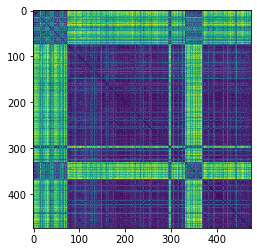

In [101]:
plt.imshow(A)
plt.show()

Apply the following sequence of refinement operations on the affinity matrix A:

Gaussian Blur with standard deviation $\sigma$
Row-wise Thresholding: For each row, set elements smaller than this row’s p-percentile to 0 (In practice, it’s better to use soft thresholding: scale these elements by a small multiplier such as 0.01)
Symmetrization: $Y_{ij} = max(X_{ij}, X_{ji})$
Diffusion: $Y = XX^T$
Row-wise Max Normalization: $Y_{ij} = X_{ij}/max_kX_{ik}$

## Applying Gaussian Blur with standard deviation $\sigma$

In [78]:
from scipy.ndimage.filters import gaussian_filter

In [79]:
# Standard deviation sigma, we may need to tune this
sigma = 1
A_gau = gaussian_filter(A, sigma)
sigma = 2
A_gau2 = gaussian_filter(A, sigma)
sigma = 0.5
A_gau4 = gaussian_filter(A, sigma)

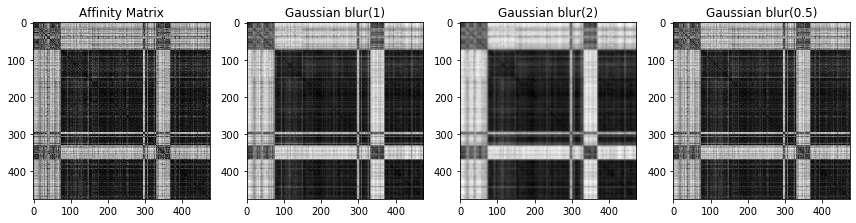

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

ax[0].imshow(A, cmap='gray')
ax[0].set_title('Affinity Matrix')

ax[1].imshow(A_gau, cmap='gray')
ax[1].set_title('Gaussian blur(1)')

ax[2].imshow(A_gau2, cmap='gray')
ax[2].set_title('Gaussian blur(2)')

ax[3].imshow(A_gau4, cmap='gray')
ax[3].set_title('Gaussian blur(0.5)')

plt.tight_layout()
plt.show()

In [80]:
sigma = 0.5 # we will select sigma as 0.5
A_gau = gaussian_filter(A, sigma)

## Step 2: Thresholding
Row-wise Thresholding: For each row, set elements smaller than this row’s p-percentile to 0 (In practice, it’s better to use soft thresholding: scale these elements by a small multiplier such as 0.01)

#### Method 1: Using p-percentile (Setting p = 25th)

In [81]:
# p = 25 # This can be tuned
# P_row = np.percentile(A_gau, p, axis=1).reshape(1, A.shape[0])
# A_thresh = A_gau.copy() # Just to create copy, you can delete it later
# A_thresh[A_gau < P_row.T] = 0

#### Method 2: threshold = 0.01

In [82]:
# using multiplier = 0.01
threshold_multiplier = 0.01
A_thresh = A_gau * threshold_multiplier

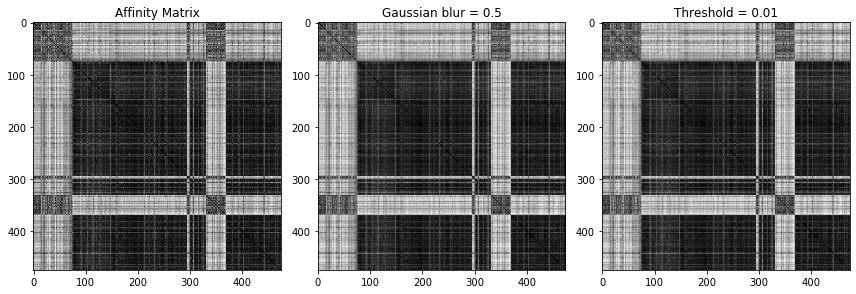

In [108]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax[0].imshow(A, cmap='gray')
ax[0].set_title('Affinity Matrix')

ax[1].imshow(A_gau, cmap='gray')
ax[1].set_title(f'Gaussian blur = {sigma}')

ax[2].imshow(A_thresh, cmap='gray')
ax[2].set_title(f'Threshold = {threshold_multiplier}')

plt.tight_layout()
plt.show()

### Symmetrization: $Y_{ij} = max(X_{ij}, X_{ji})$

In [83]:
A_sym = np.maximum(A_thresh, A_thresh.T)

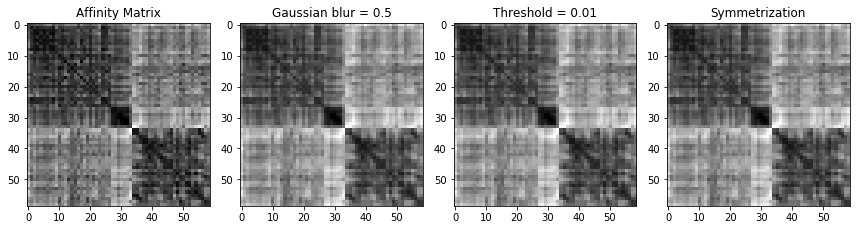

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

ax[0].imshow(A, cmap='gray')
ax[0].set_title('Affinity Matrix')

ax[1].imshow(A_gau, cmap='gray')
ax[1].set_title(f'Gaussian blur = {sigma}')

ax[2].imshow(A_thresh, cmap='gray')
ax[2].set_title(f'Threshold = {threshold_multiplier}')

ax[3].imshow(A_sym, cmap='gray')
ax[3].set_title(f'Symmetrization')

plt.tight_layout()
plt.show()

### Diffusion: $Y = XX^T$

In [84]:
A_diffusion = A_sym * A_sym.T

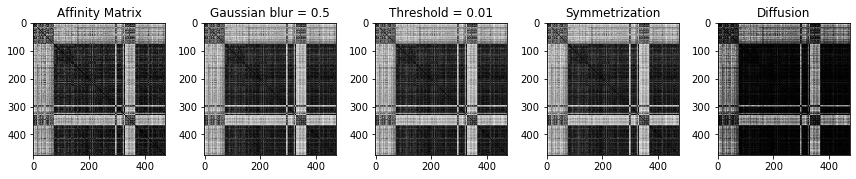

In [112]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))

ax[0].imshow(A, cmap='gray')
ax[0].set_title('Affinity Matrix')

ax[1].imshow(A_gau, cmap='gray')
ax[1].set_title(f'Gaussian blur = {sigma}')

ax[2].imshow(A_thresh, cmap='gray')
ax[2].set_title(f'Threshold = {threshold_multiplier}')

ax[3].imshow(A_sym, cmap='gray')
ax[3].set_title(f'Symmetrization')

ax[4].imshow(A_diffusion, cmap='gray')
ax[4].set_title(f'Diffusion')

plt.tight_layout()
plt.show()

### Row-wise Max Normalization: $Y_{ij} = X_{ij}/max_kX_{ik}$

In [85]:
Row_max = A_diffusion.max(axis=1).reshape(1, A_diffusion.shape[0])

print(Row_max.shape)

(1, 600)


In [86]:
A_norm = A_diffusion / Row_max.T

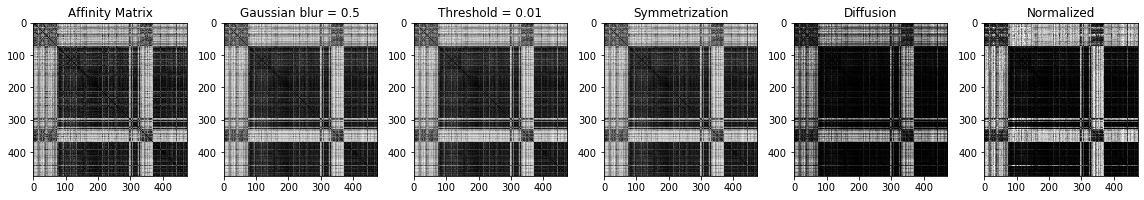

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(16, 4))

ax[0].imshow(A, cmap='gray')
ax[0].set_title('Affinity Matrix')

ax[1].imshow(A_gau, cmap='gray')
ax[1].set_title(f'Gaussian blur = {sigma}')

ax[2].imshow(A_thresh, cmap='gray')
ax[2].set_title(f'Threshold = {threshold_multiplier}')

ax[3].imshow(A_sym, cmap='gray')
ax[3].set_title(f'Symmetrization')

ax[4].imshow(A_diffusion, cmap='gray')
ax[4].set_title(f'Diffusion')

ax[5].imshow(A_norm, cmap='gray')
ax[5].set_title(f'Normalized')

plt.tight_layout()
plt.show()

## Step 4: Eigen Decomposition
After all refinement operations have been applied, perform eigen-decomposition on the refined affinity matrix. Let the $n$ eigen-values be: $\lambda_1; \lambda_2; \dots; \lambda_n$. We use the maximal eigen-gap to determine the number of clusters $k$ 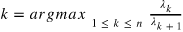 

In [87]:
# A_norm.max()
eigval, eigvec = np.linalg.eig(A_norm)

# Since eigen values cannot be negative for Positive semi definite matrix, the numpy returns negative values, converting it to positive
eigval = np.abs(eigval)

#### Reordering the eigen values

In [88]:
sorted_eigval_idx = np.argsort(eigval)[::-1]
sorted_eigval = np.sort(eigval)[::-1]


# For division according to the equation
eigval_shifted = np.roll(sorted_eigval, -1)

Take the eigen values above a threshold of 0.1, due to eigen value calculations, some eigen values as low as $1*e^-5$ cause problems

In [89]:
eigval_thresh = 0.1
sorted_eigval = sorted_eigval[sorted_eigval > eigval_thresh]
eigval_shifted = eigval_shifted[:sorted_eigval.shape[0]]

print(sorted_eigval.shape)

(236,)


#### Note: Don't take the first value for calculations, if first value is large, following equation will return k=1, and we want more than one clusters

In [90]:
# Get the argmax of the division, since its 0 indexed, add 1
k = np.argmax(sorted_eigval[1:]/eigval_shifted[1:]) + 2
print(f'Number of clusters: {k}')

Number of clusters: 3


In [91]:
# Get the indexes of eigen vectors
idexes = sorted_eigval_idx[:k]

A_eigvec = eigvec[:, idexes]

A_eigvec.shape

(600, 3)

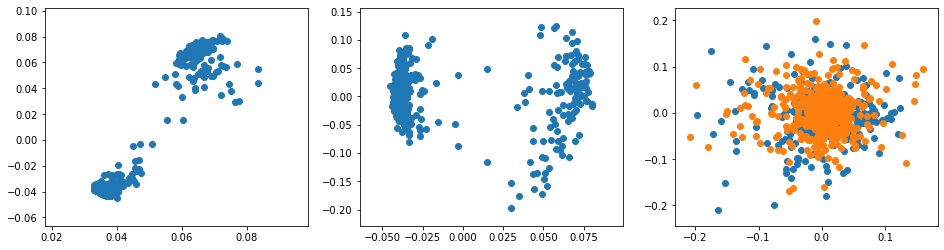

In [121]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].scatter(A_eigvec[:,0], A_eigvec[:,1])
ax[1].scatter(eigvec[:,1], eigvec[:,2])
ax[2].scatter(eigvec[:,2], eigvec[:,3])
ax[2].scatter(eigvec[:,3], eigvec[:,4])
plt.show()

## K-Means offline clustering
Like in many diarization systems, we integrated the K-Means clustering algorithm with our system. Specifically, we use K-Means++ for initialization. To determine the number of speakers $k$, we use the “elbow” of the derivatives of conditional Mean Squared Cosine Distances 1 (MSCD) between each embedding to its cluster centroid:
$k = arg max_{\substack{k \geq 1}} MSCD(k)$
We define cosine distance as $d(x, y) =(1−cos(x, y))/2$

Unit normalize the matrix because cosine similarity identical to l2-normalized euclidean distance. https://stats.stackexchange.com/a/146279/184082

In [92]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

In [93]:
A_eigvec_norm = normalize(A_eigvec) # l2 normalized

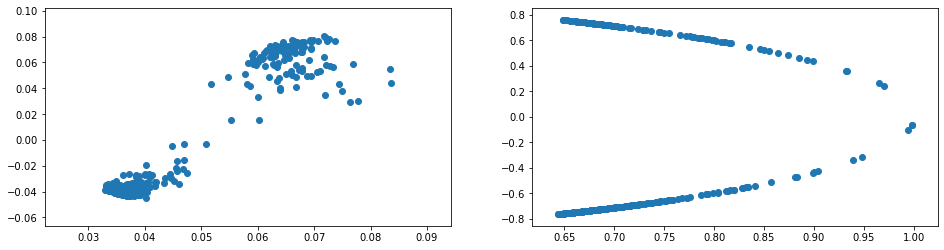

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].scatter(A_eigvec[:,0], A_eigvec[:,1])
ax[1].scatter(A_eigvec_norm[:,0], A_eigvec_norm[:,1])

plt.show()

In [94]:
random_state = 222

kmeans = KMeans(n_clusters=k, init='k-means++', random_state=random_state)

In [95]:
kmeans.fit(A_eigvec)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=222, tol=0.0001, verbose=0)

In [96]:
labels = kmeans.labels_
# labels

In [97]:
annotation = Annotation()
annotation.uri = sample_id
for jdx, speaker_id in enumerate(labels):
    segment_interval = intervals[idx][jdx]
    annotation[Segment(segment_interval[0], segment_interval[1])] = speaker_id

hypothesis_spectral = annotation.support()

In [98]:
hypothesis_uisrnn = load_rttm(uisrnn_rttm_files[sample_id])['<NA>']
reference = load_rttm(rttm_files[sample_id])[sample_id]

In [99]:
notebook.crop = Segment(60, 180)

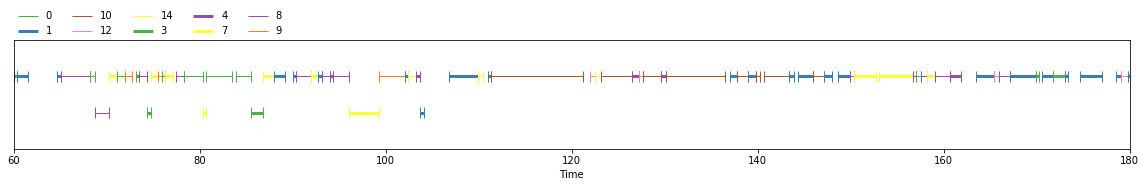

In [100]:
hypothesis_uisrnn

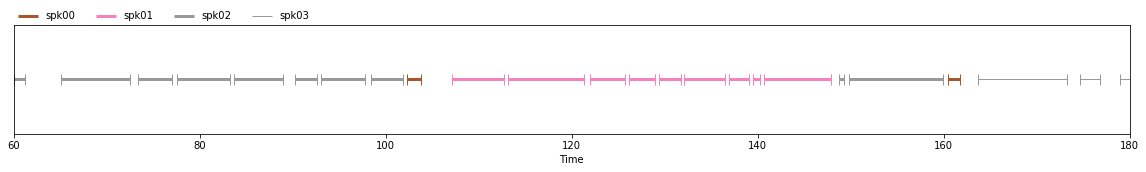

In [101]:
reference

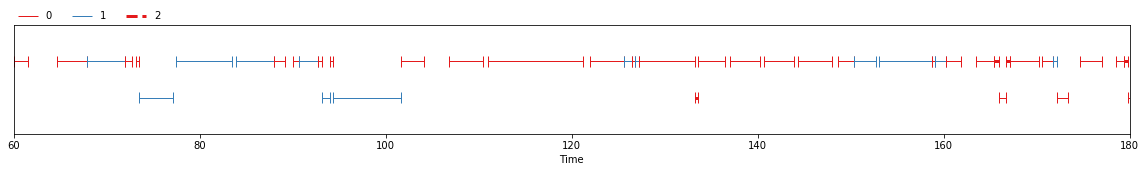

In [102]:
hypothesis_spectral

In [103]:
derMetricSpec = DiarizationErrorRate(collar=0.25)
jerMetricSpec = JaccardErrorRate(collar=0.25)
derMetricUIS = DiarizationErrorRate(collar=0.25)
jerMetricUIS = JaccardErrorRate(collar=0.25)

der_spec = derMetricSpec(reference, hypothesis_spectral, detailed = True)
jer_spec = jerMetricSpec(reference, hypothesis_spectral)
der_uis = derMetricUIS(reference, hypothesis_uisrnn, detailed = True)
jer_uis = jerMetricUIS(reference, hypothesis_uisrnn)

conf_spec = der_spec['confusion']/der_spec['total']
fa_spec = der_spec['false alarm']/der_spec['total']
md_spec = der_spec['missed detection']/der_spec['total']

conf_uis = der_uis['confusion']/der_uis['total']
fa_uis = der_uis['false alarm']/der_uis['total']
md_uis = der_uis['missed detection']/der_uis['total']

print(f'{sample_id} Speakers: (truth) {len(reference.labels())} vs {len(hypothesis_uisrnn.labels())} - {len(hypothesis_spectral.labels())} (uis - spec)')
print('------------ UIS-RNN ----------------')
print(f'DER = {100 * der_uis["diarization error rate"]:.1f}% JER = {100 * jer_uis:.1f}%')
print(f'DER_conf = {100 * conf_uis:.1f}% DER_fa = {100 * fa_uis:.1f}% DER_md = {100 * md_uis:.1f}%')
print('------------ Spectral ----------------')
print(f'DER = {100 * der_spec["diarization error rate"]:.1f}% JER = {100 * jer_spec:.1f}%')
print(f'DER_conf = {100 * conf_spec:.1f}% DER_fa = {100 * fa_spec:.1f}% DER_md = {100 * md_spec:.1f}%')

/opt/conda/lib/python3.7/site-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


epygx Speakers: (truth) 8 vs 17 - 3 (uis - spec)
------------ UIS-RNN ----------------
DER = 54.8% JER = 62.5%
DER_conf = 50.4% DER_fa = 2.8% DER_md = 1.6%
------------ Spectral ----------------
DER = 85.5% JER = 92.3%
DER_conf = 6.6% DER_fa = 0.9% DER_md = 78.0%


## Using Silhoutte score to get the best number of clusters

In [127]:
from sklearn import metrics

sil_score = []

for speakers in range(2, 10):
    kmeans = KMeans(n_clusters=speakers, init='k-means++', random_state=random_state)
    kmeans.fit(A_eigvec)
    labels = kmeans.labels_

    sil_score.append(metrics.silhouette_score(A_eigvec, labels, metric='cosine'))

In [128]:
sil_score

[0.8328810875112701,
 0.7748972087128372,
 0.7242574807467338,
 0.5942710545055866,
 0.5598170633449543,
 0.559943555324673,
 0.5163212177839684,
 0.49840577489866783]

In [129]:
np.argmax(sil_score) + 2 # +2 sinces number of speakers starts from 2

2

In [130]:
Ks = range(1, 10)
km = [KMeans(n_clusters=i) for i in Ks]
score = [1 - km[i].fit(A_eigvec).score(A_eigvec) for i in range(len(km))]

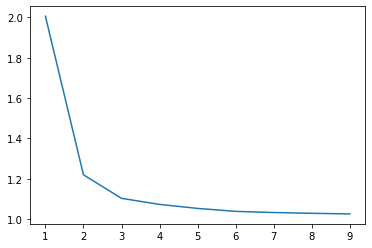

In [131]:
plt.plot(Ks, score)